# Forecasting 


In time-series, we expect patterns to persist as we progress through time. Therefore, we first 1) find the pattern (selecting the correct model) and then 2) predict the future. 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import seaborn as sns
import sklearn 
from statsmodels.tsa.arima_model import ARIMA
import yfinance
import warnings
warnings.filterwarnings('ignore')
sns.set()

# Loading the data

In [2]:
raw_data = yfinance.download(tickers="^GSPC ^FTSE ^N225 ^GDAXI",
                             start="1994-01-07", end="2019-09-01",
                             interval="1d", group_by="ticker", 
                             auto_adjust=True, treads=True)

[*********************100%***********************]  4 of 4 completed


In [3]:
df_comp = raw_data.copy()
df_comp.head()

^GDAXI                                                \
                   Open         High          Low        Close Volume   
Date                                                                    
1994-01-07  2218.959961  2227.639893  2201.820068  2224.949951    0.0   
1994-01-10  2231.840088  2238.010010  2222.000000  2225.000000    0.0   
1994-01-11  2225.429932  2235.610107  2225.179932  2228.100098    0.0   
1994-01-12  2227.120117  2227.790039  2182.060059  2182.060059    0.0   
1994-01-13  2171.500000  2183.709961  2134.100098  2142.370117    0.0   

                   ^N225                                                   \
                    Open          High           Low         Close Volume   
Date                                                                        
1994-01-07  17842.980469  18131.410156  17787.480469  18124.009766    0.0   
1994-01-10  18186.519531  18567.060547  18186.519531  18443.439453    0.0   
1994-01-11  18481.849609  18671.669922  18373.039062  18485.250000    0.0   
1994-01-12  18447.339844  18807.080078  18301.929688  18793.880859    0.0   
1994-01-13  18770.380859  18823.380859  18548.750000  18577.259766    0.0   

                 ^GSPC                                                   \
                  Open        High         Low       Close       Volume   
Date                                                                      
1994-01-07  467.089996  470.260010  467.029999  469.899994  324920000.0   
1994-01-10  469.899994  475.269989  469.549988  475.269989  319490000.0   
1994-01-11  475.269989  475.279999  473.269989  474.130005  305490000.0   
1994-01-12  474.130005  475.059998  472.140015  474.170013  310690000.0   
1994-01-13  474.170013  474.170013  471.799988  472.470001  277970000.0   

                  ^FTSE                                                
                   Open         High          Low        Close Volume  
Date                                                                   
1994-01-07  3401.399902  3446.800049  3398.699951  3446.000000    0.0  
1994-01-10  3465.699951  3468.100098  3430.000000  3440.600098    0.0  
1994-01-11  3442.500000  3442.500000  3413.500000  3413.800049    0.0  
1994-01-12  3394.800049  3402.399902  3372.000000  3372.000000    0.0  
1994-01-13  3380.699951  3383.300049  3356.899902  3360.000000    0.0

In [4]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [5]:
df_comp = df_comp.iloc[1:]
df_comp.drop(['^GSPC', '^GDAXI', '^FTSE', '^N225'], axis=1, inplace=True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

# Creating Returns

In [6]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1)*100
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1)*100
df_comp['ret_dax'] = df_comp.dax.pct_change(1)*100
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1)*100

In [7]:
# normalize
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

In [8]:
df_comp.head()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
1994-01-10,475.269989,2225.000000,3440.600098,18443.439453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-11,474.130005,2228.100098,3413.800049,18485.250000,-0.239860,-0.778935,0.139330,0.226696,100.000000,100.000000,100.000000,100.000000
1994-01-12,474.170013,2182.060059,3372.000000,18793.880859,0.008438,-1.224443,-2.066336,1.669606,-3.518009,157.194491,-1483.049430,736.495480
1994-01-13,472.470001,2142.370117,3360.000000,18577.259766,-0.358524,-0.355872,-1.818921,-1.152615,149.471895,45.686963,-1305.474516,-508.440739
1994-01-14,474.910004,2151.050049,3400.600098,18973.699219,0.516435,1.208336,0.405156,2.134004,-215.306731,-155.126650,290.787975,941.350333


# Splitting the Data 

In [9]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size].copy(), df_comp.iloc[size:].copy()

# Fitting a Model

In [10]:
model_ar = ARIMA(df.ftse, order=(1, 0, 0))  # AR(1)
results_ar = model_ar.fit()

# Simple Forecasting

In [11]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2014-07-09,1972.829956,9808.200195,6718.000000,15302.650391,0.464427,-0.304222,0.363568,-0.076789,-193.623849,39.056133,260.939581,-33.873062
2014-07-10,1964.680054,9659.129883,6672.399902,15216.469727,-0.413107,-0.678775,-1.519854,-0.563175,172.228229,87.141370,-1090.828512,-248.427258
2014-07-11,1967.569946,9666.339844,6690.200195,15164.040039,0.147092,0.266775,0.074644,-0.344559,-61.324138,-34.248669,53.573442,-151.991545
2014-07-14,1977.099976,9783.009766,6746.100098,15296.820312,0.484355,0.835549,1.206971,0.875626,-201.932230,-107.268090,866.266436,386.255523
2014-07-15,1973.280029,9719.410156,6710.500000,15395.160156,-0.193210,-0.527714,-0.650103,0.642878,80.550866,67.748084,-466.591262,283.585757


In [12]:
start_date = '2014-07-16'
end_date = '2019-01-01'

In [13]:
df_pred = results_ar.predict(start=start_date, end=end_date)

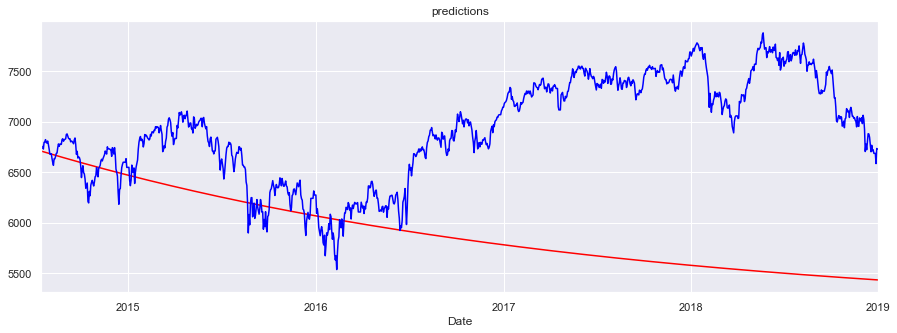

In [14]:
df_pred[start_date:end_date].plot(figsize=(15, 5), color='red')
df_test.ftse[start_date:end_date].plot(color='blue')
plt.title("predictions vs. actu")
plt.show()

Price is only decreasing which is unrealistic. This is because we are using a simple AR model. In AR, the predictions are only based on the constant and the prices from the previous period. Every new value is just a fraction of the previous one put on tope of the consant term. 

$$
Y_{t+1} = c + \phi_1 Y_t \\
Y_{t+2} = c + \phi_1 Y_{t+1} \\
... \\
Y_{t+n} = c + \phi_1 Y_{t+n-1} \\
$$

Also, remember we do not have residual values for the future. 


From here, we verify that the AR model is so bad at estimating non-stationary data.